# <a name="0">Responsible AI - Logistic Regression </a>


This notebook shows how to build a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model to predict whether an individuals' income is $\leq$ 50k or not using US census data.

__Dataset:__ 
You will download a dataset for this exercise using [folktables](https://github.com/zykls/folktables). Folktables provides an API to download data from the American Community Survey (ACS) Public Use Microdata Sample (PUMS) files which are managed by the US Census Bureau. The data itself is governed by the terms of use provided by the Census Bureau. For more information, see the [Terms of Service](https://www.census.gov/data/developers/about/terms-of-service.html).


__ML Problem:__ 
Ultimately, the goal will be to predict whether an individual's income is above \\$50,000. We will  filter the ACS PUMS data sample to only include individuals above the age of 16, who reported usual working hours of at least 1 hour per week in the past year, and an income of at least \\$100. The threshold of \\$50,000 was chosen so that this dataset can serve as a comparable substitute to the [UCI Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult). The income threshold can be changed easily to define new prediction tasks.


1. <a href="#1">Read the dataset</a>
2. <a href="#2">Data Processing</a>
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a>
    * <a href="#23">Train - Validation - Test Datasets</a>
    * <a href="#24">Data processing with Pipeline and ColumnTransformer</a>
3. <a href="#3">Train (and Tune) a Classifier</a>
4. <a href="#4">Test the Classifier</a>
5. <a href="#5">Accuracy Difference and DPPL</a>


Before building the logistic regression model, let's have a quick look at how a linear regression can be turned into a classifier.

Let's assume we want to use a feature (e.g. Class of Worker) to build a model that can predict the income class. A first step could be to plot the feature vs the model target. As class of worker is a categorical feature we introduce a little jitter to see the data points more easily.

Now that we have a plot, we can fit a linear regression through the data points.

As we notice, the linear regression line extends beyond the target values. This is not ideal as we can end up making predictions that are outside the model target range (0 or 1); a linear regression can predict values in the range ($-\inf$, $+\inf$). To squish the linear regression values into a range of 0 to 1, we need to use a helper function. For this, we can use the sigmoid function:

<center>
$\frac{1}{1 + \exp(- (w_{0} + w_{1}\cdot x_{1}+ w_{2}\cdot x_{2} + ...))}$
</center>  
<p><br></p>

Wrapping the linear regression in a sigmoid function will create a so-called Logistic Regression and allow us to make binary predictions as the resulting values will be in the rage 0-1.

We can simply read out the values on the line now to get a probability for a certain individual obtaining a certain outcome. This covers the basics of Logistic Regression and it's time to code!

本笔记本展示了如何构建 [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) 模型,以预测个人的收入是否 ≤ 50,000 美元,使用美国人口普查数据。

__数据集:__
您将使用 [folktables](https://github.com/zykls/folktables) 下载本练习的数据集。Folktables 提供了一个 API 来从美国人口普查局管理的美国社区调查(ACS)公共使用微数据样本(PUMS)文件下载数据。数据本身受人口普查局提供的使用条款约束。欲了解更多信息,请参阅[服务条款](https://www.census.gov/data/developers/about/terms-of-service.html)。

__ML 问题:__
最终目标是预测个人的收入是否超过 50,000 美元。我们将过滤 ACS PUMS 数据样本,只包括年龄在 16 岁以上、过去一年内每周报告通常工作时间至少 1 小时且收入至少 100 美元的个人。选择 50,000 美元的阈值是为了使该数据集可以作为 [UCI 成人数据集](https://archive.ics.uci.edu/ml/datasets/adult)的可比替代品。收入阈值可以很容易地更改,以定义新的预测任务。

1. <a href="#1">读取数据集</a>
2. <a href="#2">数据处理</a>
    * <a href="#21">探索性数据分析</a>
    * <a href="#22">选择特征构建模型</a>  
    * <a href="#23">训练 - 验证 - 测试数据集</a>
    * <a href="#24">使用 Pipeline 和 ColumnTransformer 进行数据处理</a>
3. <a href="#3">训练(并调优)分类器</a>
4. <a href="#4">测试分类器</a>
5. <a href="#5">准确度差异和 DPPL</a>

在构建逻辑回归模型之前,让我们快速看一下如何将线性回归转换为分类器。

假设我们想使用一个特征(例如工作类别)来构建一个模型,预测收入类别。第一步可能是绘制特征与模型目标的关系图。由于工作类别是一个分类特征,我们引入了一点抖动来更清楚地看到数据点。

现在我们有了一个图,我们可以通过数据点拟合一条线性回归线。

正如我们所注意到的,线性回归线延伸超出了目标值的范围。这是不理想的,因为我们最终可能会做出超出模型目标范围(0或1)的预测;线性回归可以预测(-inf, +inf)范围内的值。为了将线性回归值压缩到0到1的范围内,我们需要使用一个辅助函数。为此,我们可以使用 sigmoid 函数:

<center>
$\frac{1}{1 + \exp(- (w_{0} + w_{1}\cdot x_{1}+ w_{2}\cdot x_{2} + ...))}$
</center>
<p><br></p>

将线性回归包裹在 sigmoid 函数中将创建一个所谓的逻辑回归,并允许我们做出二元预测,因为结果值将在0-1范围内。

现在我们可以简单地读取线上的值来获得某个个体获得某种结果的概率。这就涵盖了逻辑回归的基础知识,是时候开始编码了!

This notebook assumes an installation of the SageMaker kernel `mlu`. In addition, libraries from a requirements.txt need to be installed:

In [1]:
!pip install --no-deps -U -q -r requirements.txt

In [2]:
# Reshaping/basic libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

# Operational libraries
import sys

sys.path.append("..")

# Fairness libraries
from folktables.acs import *
from folktables.folktables import *
from folktables.load_acs import *

# Jupyter(lab) libraries
import warnings

warnings.filterwarnings("ignore")

## 1. <a name="1">Read the dataset</a>
(<a href="#0">Go to top</a>)

To read in the dataset, we will be using [folktables](https://github.com/zykls/folktables) which provides access to the US Census dataset. Folktables contains predefined prediction tasks but also allows the user to specify the problem type.

The US Census dataset distinguishes between household and individuals. To obtain data on individuals, we use `ACSDataSource` with `survey=person`. The feature names for the US Census data follow the same distinction and use `P` for `person` and `H` for `household`, e.g.: `AGEP` refers to age of an individual.

为了读取数据集,我们将使用 [folktables](https://github.com/zykls/folktables),它提供了访问美国人口普查数据集的功能。Folktables 包含预定义的预测任务,但也允许用户指定问题类型。

美国人口普查数据集区分了家庭和个人。要获取个人数据,我们使用 `ACSDataSource` 并设置 `survey=person`。美国人口普查数据的特征名称遵循相同的区分,使用 `P` 表示 `person`(个人),使用 `H` 表示 `household`(家庭),例如: `AGEP` 指的是个人的年龄。

In [3]:
income_features = [
    "AGEP",  # age individual
    "COW",  # class of worker
    "SCHL",  # educational attainment
    "MAR",  # marital status
    "OCCP",  # occupation
    "POBP",  # place of birth
    "RELP",  # relationship
    "WKHP",  # hours worked per week past 12 months
    "SEX",  # sex
    "RAC1P",  # recorded detailed race code
    "PWGTP",  # persons weight
    "GCL",  # grand parents living with grandchildren
]

# Define the prediction problem and features
ACSIncome = folktables.BasicProblem(
    features=income_features,
    target="PINCP",  # total persons income
    target_transform=lambda x: x > 50000,
    group="RAC1P",
    preprocess=adult_filter,  # applies the following conditions; ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    postprocess=lambda x: x,  # applies post processing, e.g. fill all NAs
)

# Initialize year, duration ("1-Year" or "5-Year") and granularity (household or person)
data_source = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
# Specify region (here: California) and load data
ca_data = data_source.get_data(states=["CA"], download=True)
# Apply transformation as per problem statement above
ca_features, ca_labels, ca_group = ACSIncome.df_to_numpy(ca_data)

# Convert numpy array to dataframe
df = pd.DataFrame(
    np.concatenate((ca_features, ca_labels.reshape(-1, 1)), axis=1),
    columns=income_features + [">50k"],
)

# For further modelling we want to use only 2 groups (see DATAPREP notebook for details)
df = df[df["RAC1P"].isin([6, 8])].copy(deep=True)

## 2. <a name="2">Data Processing</a>
(<a href="#0">Go to top</a>)

### 2.1 <a name="21">Exploratory Data Analysis</a>
(<a href="#2">Go to Data Processing</a>)

We look at number of rows, columns, and some simple statistics of the dataset.

In [4]:
# Print the first five rows
# NaN means missing data
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PWGTP,GCL,>50k
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0,32.0,2.0,0.0
27,23.0,2.0,21.0,5.0,2545.0,207.0,17.0,20.0,2.0,6.0,35.0,NaN,0.0
33,18.0,1.0,16.0,5.0,9610.0,6.0,17.0,8.0,2.0,6.0,33.0,NaN,0.0
46,40.0,1.0,15.0,3.0,4140.0,303.0,16.0,22.0,1.0,8.0,38.0,2.0,0.0
49,18.0,1.0,18.0,5.0,725.0,6.0,17.0,12.0,2.0,6.0,60.0,NaN,0.0


In [5]:
# Check how many rows and columns we have in the data frame
print("The shape of the dataset is:", df.shape)

The shape of the dataset is: (55502, 13)


In [6]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55502 entries, 0 to 195664
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    55502 non-null  float64
 1   COW     55502 non-null  float64
 2   SCHL    55502 non-null  float64
 3   MAR     55502 non-null  float64
 4   OCCP    55502 non-null  float64
 5   POBP    55502 non-null  float64
 6   RELP    55502 non-null  float64
 7   WKHP    55502 non-null  float64
 8   SEX     55502 non-null  float64
 9   RAC1P   55502 non-null  float64
 10  PWGTP   55502 non-null  float64
 11  GCL     41987 non-null  float64
 12  >50k    55502 non-null  float64
dtypes: float64(13)
memory usage: 5.9 MB


We can clearly see that all columns are numerical (`dtype = float64`). However, when checking the column headers (and information at top of the notebook), we should notice that we are actually dealing with multimodal data. We expect to see a mix of categorical, numerical and potentially even text information.

Let's cast the features accordingly. We start by creating list for each feature type.

In [7]:
categorical_features = [
    "COW",
    "SCHL",
    "MAR",
    "OCCP",
    "POBP",
    "RELP",
    "SEX",
    "RAC1P",
    "GCL",
]

numerical_features = ["AGEP", "WKHP", "PWGTP"]

In [8]:
# We cast categorical features to `category`
df[categorical_features] = df[categorical_features].astype("object")

# We cast numerical features to `int`
df[numerical_features] = df[numerical_features].astype("int")

Let's check with `.info()` again to make sure the changes took effect.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55502 entries, 0 to 195664
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    55502 non-null  int64  
 1   COW     55502 non-null  object 
 2   SCHL    55502 non-null  object 
 3   MAR     55502 non-null  object 
 4   OCCP    55502 non-null  object 
 5   POBP    55502 non-null  object 
 6   RELP    55502 non-null  object 
 7   WKHP    55502 non-null  int64  
 8   SEX     55502 non-null  object 
 9   RAC1P   55502 non-null  object 
 10  PWGTP   55502 non-null  int64  
 11  GCL     41987 non-null  object 
 12  >50k    55502 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 5.9+ MB


Looks good, so we can now separate model features from model target to explore them separately.

In [10]:
model_target = ">50k"
model_features = categorical_features + numerical_features

print("Model features: ", model_features)
print("Model target: ", model_target)

Model features:  ['COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX', 'RAC1P', 'GCL', 'AGEP', 'WKHP', 'PWGTP']
Model target:  >50k


In [11]:
# Double check that that target is not accidentally part of the features
model_target in model_features

False

All good here. We made sure that the target is not in the feature list. If we find the above statement showing `True` we need to remove the target by calling `model_features.remove(model_target)`.

Let's have a look at missing values next.


#### Missing values
The quickest way to check for missing values is to use `.isna().sum()`. This will provide a count of how many missing values we have. In fact, we can also see the count of missing values with `.info()` as it provided a count of non-null values.

In [12]:
# Show missing values
df.isna().sum()

AGEP         0
COW          0
SCHL         0
MAR          0
OCCP         0
POBP         0
RELP         0
WKHP         0
SEX          0
RAC1P        0
PWGTP        0
GCL      13515
>50k         0
dtype: int64

Before starting with the plots, let's have a look at how many unique instances we have per column. This helps us avoid plotting charts with hundreds of unique values. Let's filter for columns with fewer than 10 unique instances.

In [13]:
shortlist_fts = (
    df[model_features]
    .apply(lambda col: col.nunique())
    .where(df[model_features].apply(lambda col: col.nunique()) < 10)
    .dropna()
)

print(shortlist_fts)

COW      8.0
MAR      5.0
SEX      2.0
RAC1P    2.0
GCL      2.0
dtype: float64


#### Target distribution

Let's check our target distribution.

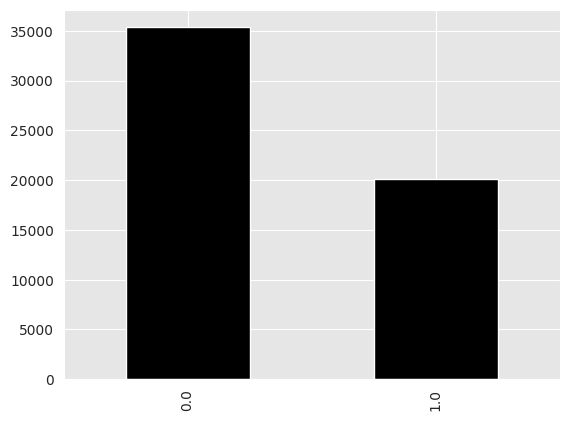

In [14]:
df[model_target].value_counts().plot.bar(color="black")
plt.show()

We notice that we are dealing with an imbalanced dataset. This means there are more examples for one type of results (here: 0; meaning individuals earning $\leq$ 50k). This is relevant for model choice and potential up-sampling or down-sampling to balance out the classes.

我们注意到这是一个不平衡的数据集。这意味着一种结果类型(这里是: 0;表示个人收入 ≤ 50,000 美元)的示例更多。这对于模型选择以及潜在的上采样或下采样来平衡类别是相关的。

#### Feature distribution(s)

Let's now plot bar charts for the shortlist features of our dataset (as per above: shortlist - feature columns with less than 10 unique instance classes).

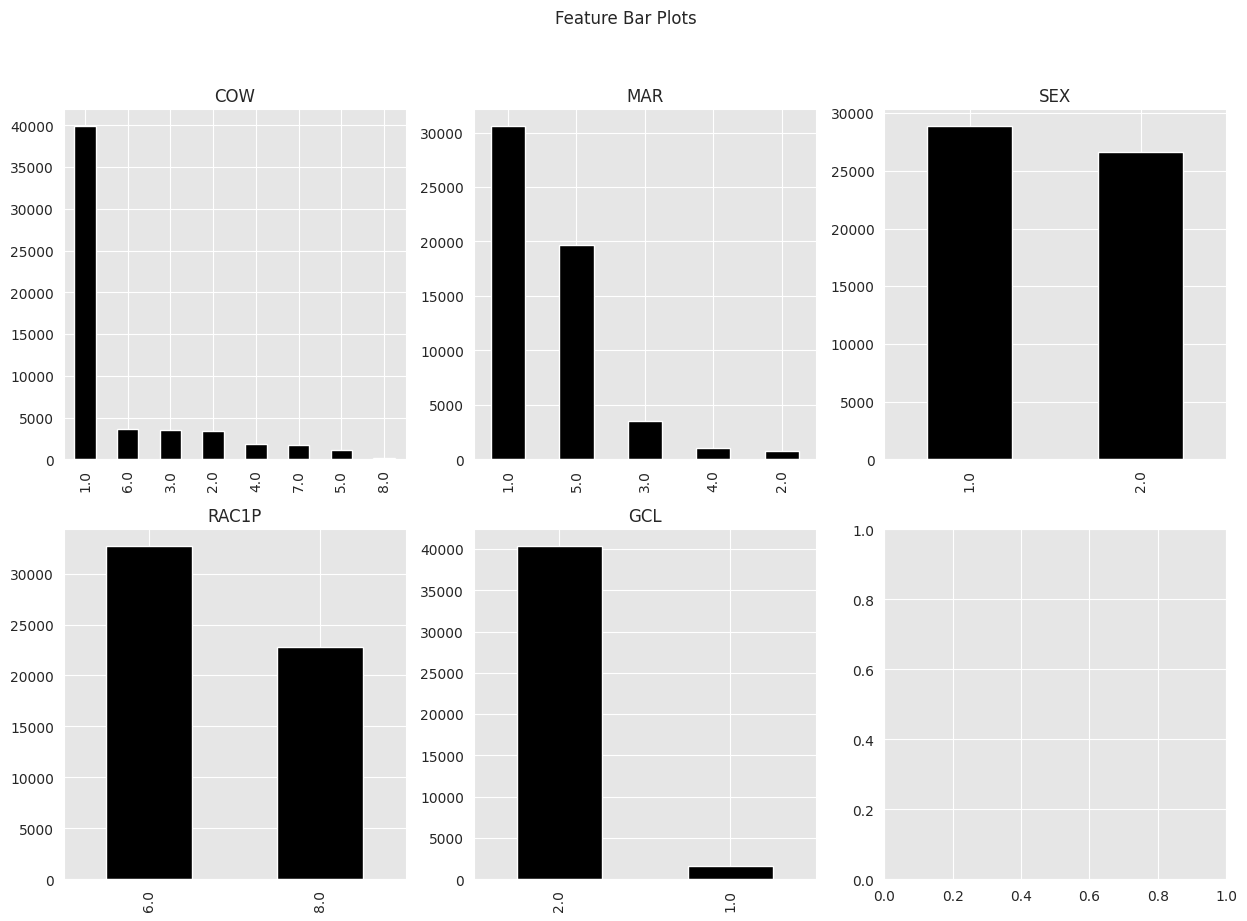

In [15]:
# 创建2x3网格子图,总尺寸15x10英寸
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  

# 设置整体图像标题  
fig.suptitle("Feature Bar Plots")

# 获取特征索引列表长度范围
fts = range(len(shortlist_fts.index.tolist()))  

# 遍历特征索引及子图
for i, ax in zip(fts, axs.ravel()):
    # 绘制当前特征值计数条形图
    df[shortlist_fts.index.tolist()[i]].value_counts().plot.bar(color="black", ax=ax)  
    # 设置当前子图标题为特征名
    ax.set_title(shortlist_fts.index.tolist()[i])  

# 显示图像
plt.show()

### 2.2 <a name="22">Select features to build the model</a>
(<a href="#2">Go to Data Processing</a>)

During the extended EDA in the DATAPREP notebook, we learned that `GCL` is a feature that is equally present for both outcome types and also contains a lot of missing values. Therefore, we can drop it from the list of features we want to use for model build. We also drop `OCCP` and `POBP` as those features have too many unique categories.

在 DATAPREP 笔记本中的扩展探索性数据分析过程中,我们了解到 `GCL` 这一特征在两种结果类型中均等分布,并且包含大量缺失值。因此,我们可以从用于构建模型的特征列表中删除它。我们还删除了 `OCCP` 和 `POBP`,因为这些特征有太多唯一类别。

In [16]:
to_remove = ["GCL", "OCCP", "POBP"]

# Drop to_remove features from the respective list(s) - if applicable
for ft in to_remove:
    if ft in model_features:
        model_features.remove(ft)
    if ft in categorical_features:
        categorical_features.remove(ft)
    if ft in numerical_features:
        numerical_features.remove(ft)

In [17]:
# Let's also clean up the dataframe and only keep the features and columns we need
df = df[model_features + [model_target]].copy(deep=True)

### 2.3 <a name="23">Train - Validation - Test Datasets</a>
(<a href="#2">Go to Data Processing</a>)

To get a training, test and validation set, we will use sklearn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

为了获得训练集、测试集和验证集,我们将使用 scikit-learn 的 [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) 函数。

In [18]:
train_data, test_data = train_test_split(
    df, test_size=0.1, shuffle=True, random_state=23
) # 将数据划分为训练集和测试集,测试集占10%

train_data, val_data = train_test_split(
    train_data, test_size=0.15, shuffle=True, random_state=23
) # 再将训练集的15%划分为验证集

# 打印训练集、测试集和验证集的形状
print(
    "Train - Test - Validation datasets shapes: ",
    train_data.shape,
    test_data.shape,
    val_data.shape,
)

Train - Test - Validation datasets shapes:  (42458, 10) (5551, 10) (7493, 10)


### 2.4 <a name="24">Data processing with Pipeline and ColumnTransformer</a>
(<a href="#2">Go to Data Processing</a>)

Let's build a full model pipeline. We need pre-processing split per data type, and then combine everything back into a composite pipeline along with a model. To achieve this, we will use sklearns `Pipeline` and `ColumnTransformer`.

__Step 1 (set up pre-processing per data type):__
> For the numerical features pipeline, the __numerical_processor__ below, we impute missing values with the mean using sklearn's `SimpleImputer`, followed by a `MinMaxScaler` (don't have to scale features when using Decision Trees, but it's a good idea to see how to use more data transforms). If different processing is desired for different numerical features, different pipelines should be built - just like shown below for the two text features.

 > In the categorical features pipeline, the __categorical_processor__ below, we impute with a placeholder value and encode with sklearn's `OneHotEncoder`. If computing memory is an issue, it is a good idea to check categoricals' unique values, to get an estimate of many dummy features will be created by one-hot encoding. Note the __handle_unknown__ parameter that tells the encoder to ignore (rather than throw an error for) any unique value that might show in the validation/and or test set that was not present in the initial training set.
 
__Step 2 (combining pre-processing methods into a transformer):__ 
 > The selective preparations of the dataset features are then put together into a collective `ColumnTransformer`, to be finally used in a Pipeline along with an estimator. This ensures that the transforms are performed automatically on the raw data when fitting the model and when making predictions, such as when evaluating the model on a validation dataset via cross-validation or making predictions on a test dataset in the future.
   
__Step 3 (combining transformer with a model):__ 
> Combine `ColumnTransformer` from Step 2 with a selected algorithm in a new pipeline. For example, the algorithm could be a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for classification problems.

让我们构建一个完整的模型管道。我们需要按数据类型进行预处理,然后将所有内容组合回一个复合管道,以及一个模型。为了实现这一点,我们将使用 scikit-learn 的 `Pipeline` 和 `ColumnTransformer`。

__步骤 1 (为每种数据类型设置预处理):__
> 对于数值特征管道 __numerical_processor__,我们使用 scikit-learn 的 `SimpleImputer` 用平均值填充缺失值,然后进行 `MinMaxScaler` (在使用决策树时不必对特征进行缩放,但了解如何使用更多数据转换还是很好的)。如果需要对不同的数值特征进行不同的处理,应该构建不同的管道 - 就像下面为两个文本特征所示的那样。

> 在分类特征管道 __categorical_processor__ 中,我们用占位值填充缺失值,并使用 scikit-learn 的 `OneHotEncoder` 进行编码。如果计算内存是个问题,最好检查分类特征的唯一值,以估计一次性编码将创建多少虚拟特征。注意 __handle_unknown__ 参数,它告诉编码器忽略(而不是抛出错误)任何可能在验证集和/或测试集中出现但在初始训练集中不存在的唯一值。

__步骤 2 (将预处理方法组合成一个转换器):__
> 然后,将数据集特征的选择性准备工作组合到一个集体 `ColumnTransformer` 中,最终与一个估计器一起用于管道。这确保了在拟合模型和进行预测时(例如通过交叉验证在验证数据集上评估模型或将来在测试数据集上进行预测)原始数据会自动执行转换。

__步骤 3 (将转换器与模型相结合):__
> 将步骤 2 中的 `ColumnTransformer` 与所选算法(例如 [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) 用于分类问题)组合到一个新的管道中。

In [22]:
### STEP 1 ###
##############

# 预处理数值特征
numerical_processor = Pipeline(
    [("num_imputer", SimpleImputer(strategy="mean")), ("num_scaler", MinMaxScaler())]
)
# 创建一个Pipeline,首先使用SimpleImputer填充数值特征中的缺失值(使用均值填充),然后使用MinMaxScaler将数值特征缩放到0-1范围

# 预处理分类特征  
categorical_processor = Pipeline(
    [
        ("cat_imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("cat_encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
# 创建另一个Pipeline,首先使用SimpleImputer填充分类特征中的缺失值(使用"missing"常量填充),然后使用OneHotEncoder对分类特征进行一次性编码,忽略训练集中未出现的任何唯一值

### STEP 2 ###
##############

# 将上面所有数据预处理器组合起来
data_processor = ColumnTransformer(
    [
        ("numerical_processing", numerical_processor, numerical_features),
        ("categorical_processing", categorical_processor, categorical_features),
    ]
)
# 使用ColumnTransformer将数值特征处理器和分类特征处理器组合起来,分别作用于数值特征列和分类特征列

### STEP 3 ###
##############

# 构建最终的管道,包含数据转换器和估计器模型
pipeline = Pipeline(
    [
        ("data_processing", data_processor),
        ("lg", LogisticRegression(solver="lbfgs", penalty=None)),
    ]
)
# 创建Pipeline,首先使用data_processor进行数据预处理转换,然后将转换后的数据输入LogisticRegression模型进行训练
# 构建Pipeline的目的是将数据预处理和模型训练整合在一起,使原始数据在拟合模型和预测时自动进行转换

# 可视化管道
from sklearn import set_config
set_config(display="diagram")
pipeline
# 设置可视化选项,显示Pipeline的流程图,方便调试和理解

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['AGEP', 'WKHP', 'PWGTP']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['COW', 'SCHL', 'MAR', 'RELP',
                                                   'SEX', 'RAC1P'])])),
                ('lg', LogisticRegression(penalty=None))])

## 3. <a name="3">Train a Classifier</a>
(<a href="#0">Go to top</a>)

We use the pipeline with the desired data transformers, along with a Logistic Regression estimator for training.

我们使用包含所需数据转换器和逻辑回归估计器的管道进行训练。

构建管道的目的是将数据预处理和模型训练整合在一起,确保在模型拟合和预测时,原始数据能够自动进行必要的转换。通过将数据转换器和估计器模型组合到一个 Pipeline 中,可以简化机器学习工作流程,避免手动执行每个预处理步骤。

Pipeline 还提供了一种标准化的方式来命名每个步骤,并在需要时访问和调整每个步骤的参数,例如进行超参数调优。这种模块化设计使得代码更易于维护和扩展。


### Model Training

We train the classifier with`.fit()` on our training dataset. 

In [23]:
# 获取训练数据用于训练分类器
X_train = train_data[model_features]
y_train = train_data[model_target]

# 使用训练数据拟合分类器
# 训练数据通过Pipeline进行以下处理:
#   1. 缺失值填充(使用训练数据的均值)
#   2. 特征缩放(使用训练数据的最小/最大值)
#   3. 最终用于拟合模型
pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['AGEP', 'WKHP', 'PWGTP']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['COW', 'SCHL', 'MAR', 'RELP',
                                                   'SEX', 'RAC1P'])])),
                ('lg', LogisticRegression(penalty=None))])

这段代码首先从训练数据 train_data 中分离出特征 X_train 和目标 y_train。

然后,它使用 pipeline.fit(X_train, y_train) 来拟合分类器模型。在这个过程中:

训练数据 X_train 通过 Pipeline 中的 data_processor 进行预处理转换。
对于数值特征,缺失值使用训练数据的均值进行填充,然后使用训练数据的最小/最大值进行缩放。
对于分类特征,缺失值使用 "missing" 常量进行填充,然后执行一次性编码。
转换后的训练数据被输入到 Pipeline 中的逻辑回归模型 LogisticRegression 进行拟合。
通过这种方式,原始训练数据在进入模型之前会自动进行所需的预处理转换,从而简化了数据准备和模型训练的流程。同时,Pipeline 确保了在后续的预测过程中也会应用相同的转换,保证了数据的一致性。

We won't tune the classifier at this point, and simply use the validation set as additional test:

In [24]:
# 获取验证数据用于调优分类器
X_val = val_data[model_features]
y_val = val_data[model_target]

# 使用验证数据进行预测
y_val_pred = pipeline.predict(X_val)

# 评估模型在验证集上的表现
print("Model performance on the validation set:")
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))

Model performance on the validation set:
Validation accuracy: 0.8070198852262112


这段代码的作用是:

从验证数据 val_data 中分离出特征 X_val 和目标 y_val。

使用之前在训练数据上拟合的 pipeline 对验证数据 X_val 进行预测,得到预测结果 y_val_pred。

在这个过程中,验证数据会自动通过 Pipeline 中的 data_processor 进行相同的预处理转换,确保了数据的一致性。
使用 accuracy_score 函数计算模型在验证集上的准确率,并打印出来。

这个指标可以用于评估模型的泛化能力,并根据需要进行调优(如超参数调整、特征选择等)。
通过在独立的验证集上评估模型,我们可以更好地了解模型的真实表现,并避免过拟合训练数据。验证集的评估结果可以指导我们对模型进行改进,从而获得更好的泛化能力。

## 4. <a name="4">Test the Classifier</a>
(<a href="#0">Go to top</a>)

Let's now evaluate the performance of the trained classifier on the test dataset. We use `.predict()` this time. 


In [25]:
# 获取测试数据用于评估分类器的性能
X_test = test_data[model_features]
y_test = test_data[model_target]

# 使用拟合后的模型对测试数据进行预测
# 测试数据通过Pipeline进行以下处理:
#   1. 缺失值填充(使用训练数据的均值)
#   2. 特征缩放(使用训练数据的最小/最大值)
#   3. 最终用于进行预测
test_predictions = pipeline.predict(X_test)

# 评估模型在测试集上的表现
print("Model performance on the test set:") 
print("Test accuracy:", accuracy_score(y_test, test_predictions))

Model performance on the test set:
Test accuracy: 0.7942713024680238


这段代码的作用是:

从测试数据 test_data 中分离出特征 X_test 和目标 y_test。

使用之前在训练数据上拟合的 pipeline 对测试数据 X_test 进行预测,得到预测结果 test_predictions。

测试数据会自动通过 Pipeline 中的 data_processor 进行相同的预处理转换,确保了数据的一致性。
预处理参数(如缺失值填充的均值、特征缩放的最小/最大值)都来自于训练数据,避免了数据泄露。
使用 accuracy_score 函数计算模型在测试集上的准确率,并打印出来。

这是评估模型泛化能力的最终指标,能够反映出模型在看不见的新数据上的真实表现。
通过在最终的测试集上评估模型,我们可以获得模型的无偏估计性能,从而决定是否需要进一步改进模型或者已经可以将其投入生产环境。测试集评估是机器学习项目中一个非常重要的环节。

## 5. <a name="5">Accuracy Difference and DPPL</a>
(<a href="#0">Go to top</a>)

### DPPL
DPPL (Difference in Proportion of Predicted Labels) is an extension of DPL where the outcome we compare is the prediction the model creates (rather than the ground truth value). The equation remains basically the same, only we are counting positive outcomes as per model prediction:


$\large DPPL = \frac{\hat{n}_{pred>50k \wedge RAC1P=6}}{n_{RAC1P=6}} - \frac{\hat{n}_{pred>50k \wedge RAC1P=8}}{n_{RAC1P=8}}$

To calculate DPPL more easily, let's write a function for it that can take different parameters.

DPPL(差异预测标签比例)是DPL(差异标签比例)的扩展,我们比较的是模型的预测结果(而不是真实标签值)。公式基本保持不变,只是我们根据模型预测计算正面结果:

$\large DPPL = \frac{\hat{n}_{pred>50k \wedge RAC1P=6}}{n_{RAC1P=6}} - \frac{\hat{n}_{pred>50k \wedge RAC1P=8}}{n_{RAC1P=8}}$

为了更方便地计算DPPL,让我们编写一个函数,可以传入不同的参数。

In [26]:
def dpl(sensitive_attribute_name, attr_val, target, dataframe):
    """根据指定的目标计算 DPL 或 DPPL。"""
    for val in attr_val:
        # 计算每个属性值下的正面结果数量
        globals()[f"n_pos_gr{val}"] = len(
            dataframe[
                (dataframe[target] == 1) & (dataframe[sensitive_attribute_name] == val)
            ]
        )
        # 计算每个属性值下的总数量
        globals()[f"n_gr{val}"] = len(
            dataframe[dataframe[sensitive_attribute_name] == val]
        )

    # 计算 DPL 或 DPPL
    dpl = n_pos_gr6 / n_gr6 - n_pos_gr8 / n_gr8
    return dpl

In [27]:
# 创建包含预测结果和敏感属性的数据框
dpl_df = pd.concat(
    [
        test_data.reset_index(drop=True)[["RAC1P", ">50k"]],  # 从测试数据中获取RAC1P和真实标签
        pd.Series(test_predictions, name="y_test_pred"),  # 添加预测结果列
    ],
    axis=1,
)

# 计算DPPL
dppl = dpl("RAC1P", [6, 8], "y_test_pred", dpl_df)
print(f"DPPL on test set: {dppl:.4f}")

DPPL on test set: 0.3900


Let's compare this to the original DPL value (the difference in proportion of labels in the original dataframe):

In [28]:
dpl("RAC1P", [6, 8], ">50k", test_data)

0.25824245532436

The DPL value is smaller than the DPPL value. It seems that the model is producing a more biased output compared to the ground truth data. This could be due to the different success rates for the different groups in our model. Generally, models will make better predictions for the larger group (meaning, the larger group drives the overall model performance and whatever outcome is dominant in the larger group, will occur more frequently in the predictions).

Let's see if we can observe this behavior in our model predictions and calculate overall accuracy first.

DPL 值比 DPPL 值小,这表明与真实数据相比,模型产生的输出存在更大的偏差。这可能是由于不同组在我们的模型中具有不同的成功率所导致的。通常,模型会对较大的组做出更好的预测(即较大的组驱动了整体模型性能,并且在较大组中占主导地位的结果将在预测中出现更多次)。

让我们先观察一下模型预测中是否存在这种行为,并计算整体准确率。


In [29]:
# Accuracy score across all groups
accuracy_score(dpl_df[">50k"], dpl_df["y_test_pred"])

0.7942713024680238

Let's also have a look at the accuracy difference between `RAC1P=6` and `RAC1P=8`.

In [30]:
# Accuracy score for RAC1P=1
acc_gr6 = accuracy_score(
    dpl_df[dpl_df["RAC1P"] == 6][">50k"], dpl_df[dpl_df["RAC1P"] == 6]["y_test_pred"]
)

acc_gr6

0.7731143552311436

In [31]:
# Accuracy score for RAC1P=8
acc_gr8 = accuracy_score(
    dpl_df[dpl_df["RAC1P"] == 8][">50k"], dpl_df[dpl_df["RAC1P"] == 8]["y_test_pred"]
)

acc_gr8

0.8250110472823685

### Accuracy Difference
We calculate the Accuracy Difference by subtracting the two values we calculated above:

In [32]:
acc_gr6 - acc_gr8

-0.051896692051224935

As expected, the accuracy for the group we assume to be at an advantage is higher than the accuracy for the disfavored group. We can dive deeper to see what's going on and plot the confusion matrix and we should also look at confidence intervals.

正如预期的那样,我们假设处于有利地位的组的准确率高于不利组。我们可以深入研究发生了什么,绘制混淆矩阵,同时也应该查看置信区间。

In [33]:
# Confusion matrix for RAC1P=8
confusion_matrix(
    dpl_df[dpl_df["RAC1P"] == 8][">50k"], dpl_df[dpl_df["RAC1P"] == 8]["y_test_pred"]
).ravel()

array([1720,   84,  312,  147])

Let's compare this confusion matrix with the one for the favored group.

让我们比较一下整体混淆矩阵和有利组的混淆矩阵。

混淆矩阵的概念:

想象一下,你是一个安检员,负责检查旅客的行李箱是否含有违禁品。混淆矩阵就像是记录你工作表现的一张表格。

这张表格有四个格子,分别对应四种不同的情况:

1) 真正例(True Positives): 这个格子记录了你正确检测出行李箱中有违禁品的次数。就像你成功查获了携带枪支的旅客。

2) 假正例(False Positives): 这个格子记录了你错误地认为行李箱中有违禁品的次数。就像你误报了一个装满普通物品的行李箱。

3) 假负例(False Negatives): 这个格子记录了你没有检测出行李箱中有违禁品的次数。就像你错失了一个携带爆炸物的旅客。

4) 真负例(True Negatives): 这个格子记录了你正确地认为行李箱中没有违禁品的次数。就像你正确放行了一个装满衣物的行李箱。

一个理想的安检员应该尽量减少假正例和假负例的数量,提高真正例和真负例的数量。混淆矩阵就是用来评估你的工作表现,看看你在这四种情况下的统计数据如何。

通过分析混淆矩阵,你可以发现自己的薄弱环节,比如经常漏检某种违禁品,或者对某些无辜旅客过于怀疑。有了这些信息,你就可以针对性地改进工作,提高检测的准确性和公平性。

混淆矩阵就像是记录你工作表现的一张成绩单,能够清晰地展示出你的优缺点所在。通过不断分析和改进,你就能成为一名优秀的安检员。

In [34]:
# Confusion matrix for RAC1P=1
confusion_matrix(
    dpl_df[dpl_df["RAC1P"] == 6][">50k"], dpl_df[dpl_df["RAC1P"] == 6]["y_test_pred"]
).ravel()

array([1348,  424,  322, 1194])

To create confidence intervals, we need to create samples first. We can then repeatedly calculate the metric that interests us from the new sample and eventually summarize in aggregate (or visualize in e.g., box plots).

为了创建置信区间,我们首先需要创建样本。然后,我们可以重复计算我们感兴趣的指标的新样本,并最终进行汇总(或者在例如箱线图中进行可视化)。

In [35]:
def sampling(n_iter=10, group=1):
    tn_ls, fp_ls, fn_ls, tp_ls = [], [], [], []
    output = {}
    for i in range(0, n_iter):
        sample = resample(test_data, replace=True, n_samples=5551, stratify=None)
        sample = sample[sample["RAC1P"] == group]
        tn, fp, fn, tp = confusion_matrix(
            sample[model_target], pipeline.predict(sample[model_features])
        ).ravel()
        tn_ls.append(tn), fp_ls.append(fp), fn_ls.append(fn), tp_ls.append(tp)
    output["tn"] = tn_ls
    output["fp"] = fp_ls
    output["fn"] = fn_ls
    output["tp"] = tp_ls
    return pd.DataFrame.from_dict(output, orient="columns", dtype=None, columns=None)

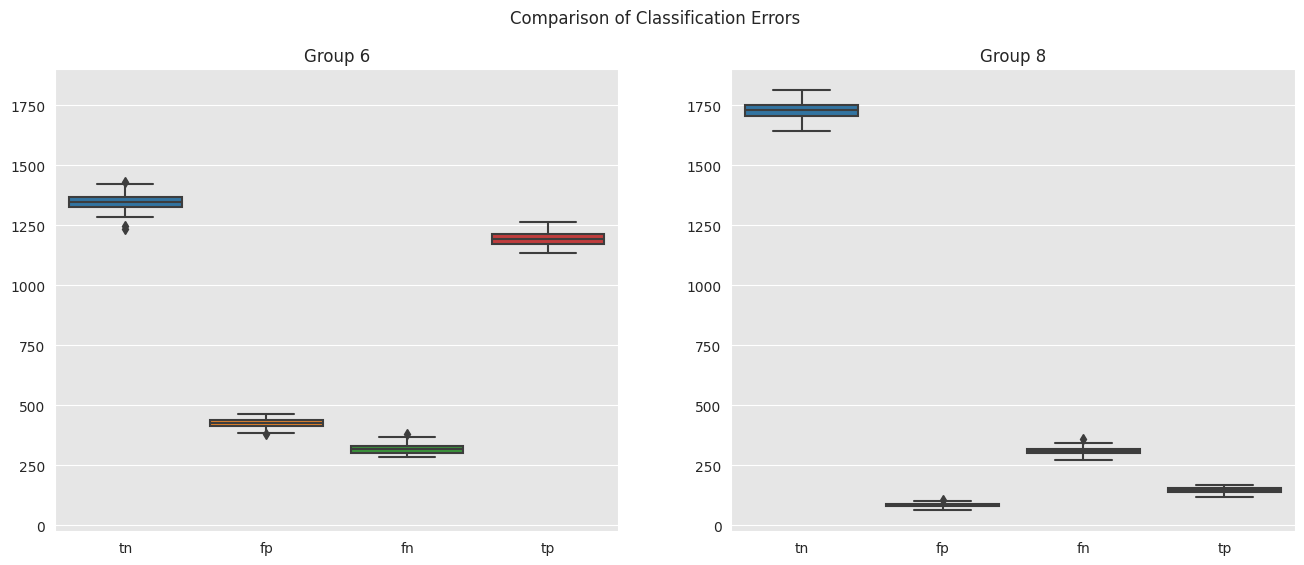

In [36]:
%matplotlib inline
# Initialize figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Set title of figure
fig.suptitle("Comparison of Classification Errors")

# Set title
ax1.title.set_text("Group 6")
ax2.title.set_text("Group 8")

# Create boxplot
sns.boxplot(data=sampling(n_iter=100, group=6), ax=ax1)
sns.boxplot(data=sampling(n_iter=100, group=8), ax=ax2)

# Align y-axis
ax1.sharey(ax2)

Generally we can see that group 6 has a much higher share of positive predictions than group 8 (add FP + TP for total positive predictions). Furthermore, we observe that the errors are not balanced between false positives and false negatives for the disfavored group (whereas they are within the error bounds for the favored group). For group 8 there is a larger share of false negatives (predicted salary as $\leq$ 50k, when it was actually higher) than false positives. 
This is concerning:
- The model is penalizing individuals that should have been predicted as positive $\rightarrow$ if this model is used to show job ads based on a 50k salary threshold, a lot of individuals that should have been eligible to see the ad, won't receive it. This causes a negative reinforcement of existing bias.
- The imbalance is not as drastic for the favored group. For this group, we observe more false positives, than false negatives. This means that people are incorrectly predicted positive for the favored group. This causes further amplification of the bias.

一般来说,我们可以看到第6组被预测为"高收入"的比例远远高于第8组(把错判为高收入和正确判断为高收入加在一起就是总的"高收入"预测)。另外,对于第8组这个"不利组",模型判断错误的情况是不平衡的(而对第6组这个"有利组"来说,错误判断还在可接受的范围内)。对第8组来说,模型把实际高收入的人错判为低收入的情况,比把实际低收入的人错判为高收入的情况要多得多。

这就令人非常担心了:
- 模型在惩罚那些应该被预测为"高收入"的人 → 如果用这个模型根据5万美元的收入门槛来推送工作广告,很多应该能看到广告的人反而看不到。这会加重已有的偏见。
- 对第6组这个"有利组"来说,情况没有那么极端。对这个组,模型把实际低收入的人错判为高收入的情况更多一些。这会进一步放大偏见。

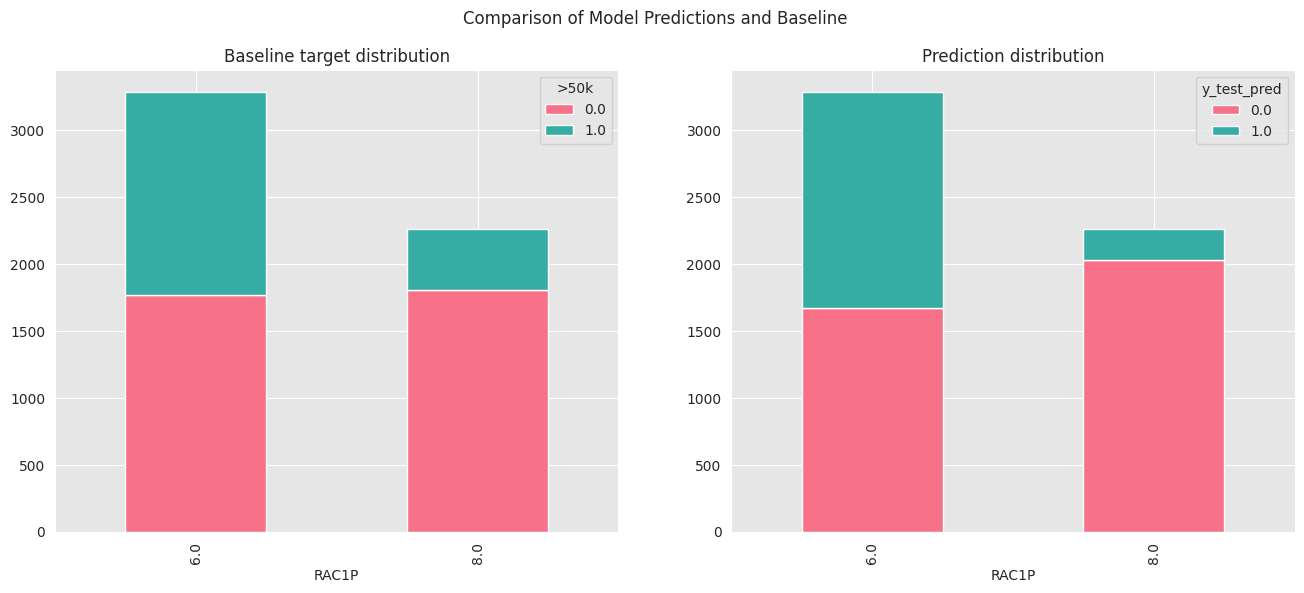

In [37]:
%matplotlib inline
# Initialize figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Set title of figure
fig.suptitle("Comparison of Model Predictions and Baseline")

# Set title
ax1.title.set_text("Baseline target distribution")
ax2.title.set_text("Prediction distribution")

# Create plots
dpl_df.groupby(["RAC1P", model_target]).size().unstack().plot(
    kind="bar", stacked=True, color=sns.husl_palette(2), ax=ax1
)
dpl_df.groupby(["RAC1P", "y_test_pred"]).size().unstack().plot(
    kind="bar", stacked=True, color=sns.husl_palette(2), ax=ax2
)
# Align y-axis
ax2.sharey(ax1)

We notice that the predictions are less favorable for the disfavored group with even more '0' outcomes than the baseline (which itself was already very biased).

我们注意到,对于不利群体,预测结果更加不利,甚至比基线(本身已经存在很大偏差)还有更多的"0"结果。

This is the end of the notebook.